<a href="https://colab.research.google.com/github/appliedcode/mthree-c422/blob/mthree-c422-Avantika/Exercises/day-13/Bias/Bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***

# Practice Exercise Set: Understanding Bias in Algorithms

This set focuses on exploring data, algorithmic, and societal bias, methods to detect and mitigate bias, and applying fairness metrics to evaluate models.

***

## 1. Types of Bias in Algorithms

### Exercise 1.1 — Explore Types of Bias (Conceptual)

- **Data Bias:** Bias arising from unrepresentative or skewed datasets (e.g., selection bias, sampling bias).
- **Algorithmic Bias:** Bias introduced by model choices or design (e.g., feature selection bias, inductive bias).
- **Societal Bias:** Pre-existing societal inequalities reflected in data and models (e.g., historical discrimination, stereotype bias).


### Exercise 1.2 — Identify Bias Sources

- Given a dataset of loan applications with demographic attributes, reflect on possible sources of each bias type. For example, data bias may come from under-sampling minorities, algorithm bias from model ignoring fairness, and societal bias from systemic economic disparities.

*(This task is primarily conceptual and discussion-based.)*

***

## 2. Techniques for Detecting Bias

We’ll use a synthetic loan dataset for hands-on detection.

### Exercise 2.1 — Data Bias Detection

- Analyze demographic group distribution and label imbalance.
- Perform chi-square test for independence.
- Visualize approval rates by groups.

Ethnicity
Group_A    0.481
Group_B    0.294
Group_C    0.225
Name: proportion, dtype: float64
Ethnicity
Group_A    0.704782
Group_B    0.421769
Group_C    0.457778
Name: Loan_Approved, dtype: float64
Chi-square test p-value: 1.1871666628169174e-16


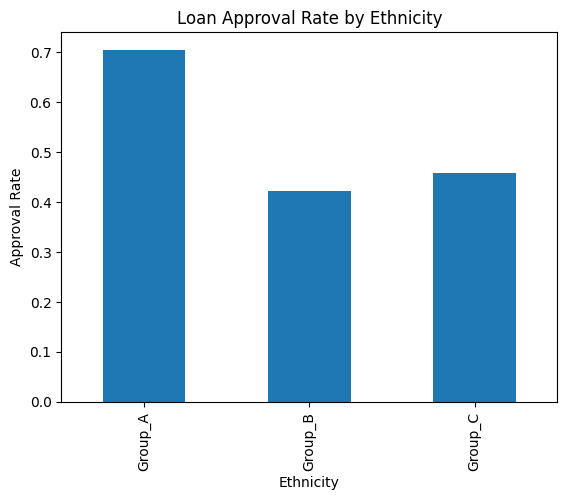

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Generate synthetic data
np.random.seed(0)
n = 1000
genders = ['Male', 'Female']
ethnicities = ['Group_A', 'Group_B', 'Group_C']

data = pd.DataFrame({
    'Gender': np.random.choice(genders, n, p=[0.6, 0.4]),
    'Ethnicity': np.random.choice(ethnicities, n, p=[0.5, 0.3, 0.2])
})

# Simulated loan approvals with bias: Group_A has higher approval rate
data['Loan_Approved'] = np.where(
    (data['Ethnicity'] == 'Group_A'),
    np.random.choice([1, 0], n, p=[0.7, 0.3]),
    np.random.choice([1, 0], n, p=[0.4, 0.6])
)

# Group distribution
print(data['Ethnicity'].value_counts(normalize=True))

# Approval rates by Ethnicity
approval_rates = data.groupby('Ethnicity')['Loan_Approved'].mean()
print(approval_rates)

# Chi-square test
contingency_table = pd.crosstab(data['Ethnicity'], data['Loan_Approved'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square test p-value: {p}")

# Bar plot
approval_rates.plot(kind='bar', title='Loan Approval Rate by Ethnicity')
plt.ylabel('Approval Rate')
plt.show()

### Explanation:

- Imbalanced group sizes and differing approval rates indicate potential data bias.
- A small p-value from chi-square suggests approval depends on ethnicity.

***

### Exercise 2.2 — Algorithmic Bias Detection

- Train a baseline classifier (e.g. logistic regression).
- Compute accuracy, True Positive Rate (TPR), False Positive Rate (FPR) per group.
- Check feature importance for sensitive attributes.



In [2]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Prepare data
X = pd.get_dummies(data[['Gender', 'Ethnicity']], drop_first=True)
y = data['Loan_Approved']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Group-wise metrics function
def group_metrics(df, labels, preds, group_col):
    results = {}
    for g in df[group_col].unique():
        idx = df[group_col]==g
        tn, fp, fn, tp = confusion_matrix(labels[idx], preds[idx]).ravel()
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        acc = (tp + tn) / (tp + tn + fp + fn)
        results[g] = {'Accuracy': acc, 'TPR': tpr, 'FPR': fpr}
    return pd.DataFrame(results)

df_test = X_test.copy()
df_test['Gender'] = data.loc[y_test.index, 'Gender'].values
df_test['Ethnicity'] = data.loc[y_test.index, 'Ethnicity'].values

metrics_gender = group_metrics(df_test, y_test, y_pred, 'Gender')
metrics_ethnicity = group_metrics(df_test, y_test, y_pred, 'Ethnicity')

print("Metrics by Gender:")
print(metrics_gender)
print("\nMetrics by Ethnicity:")
print(metrics_ethnicity)

# Feature importance (coefficients)
coef = pd.Series(model.coef_[0], index=X.columns)
print("\nFeature importance:")
print(coef.sort_values(ascending=False))

Metrics by Gender:
              Male    Female
Accuracy  0.652850  0.682243
TPR       0.605263  0.566667
FPR       0.278481  0.170213

Metrics by Ethnicity:
           Group_C   Group_B   Group_A
Accuracy  0.513514  0.623656  0.774436
TPR       0.000000  0.000000  1.000000
FPR       0.000000  0.000000  1.000000

Feature importance:
Gender_Male         -0.202833
Ethnicity_Group_B   -0.917951
Ethnicity_Group_C   -0.923650
dtype: float64


### Explanation:

- Examine if performance metrics differ substantially between groups.
- Large differences in TPR or FPR indicate algorithmic bias.
- Sensitive features with large coefficients may drive bias.

***

## 3. Techniques for Mitigating Bias

### Exercise 3.1 — Pre-processing: Re-sampling to Balance Dataset

In [ ]:
from sklearn.utils import resample

# Resample minority group to balance dataset
df_minority = data[data['Ethnicity']=='Group_C']
df_majority = data[data['Ethnicity']!='Group_C']

df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)

df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Recheck approval rates
print(df_balanced['Ethnicity'].value_counts(normalize=True))
print(df_balanced.groupby('Ethnicity')['Loan_Approved'].mean())

Ethnicity
Group_C    0.500000
Group_A    0.310323
Group_B    0.189677
Name: proportion, dtype: float64
Ethnicity
Group_A    0.704782
Group_B    0.421769
Group_C    0.441290
Name: Loan_Approved, dtype: float64


### Exercise 3.2 — In-processing: Train with Fairness Constraint (Sample for illustration)

- Implement fairness constraints if toolkits like `aif360` or other libraries are available (not shown here for simplicity).


### Exercise 3.3 — Post-processing: Adjust Decision Thresholds per Group

In [ ]:
# Example: Compute thresholds to equalize TPR or FPR (high level exercise)
# Requires predicted probabilities and per-group ROC curves (not shown due to complexity)

***

## 4. Fairness Metrics and Evaluation

### Exercise 4.1 — Compute Common Fairness Metrics

In [ ]:
def demographic_parity(y_true, y_pred, group):
    rates = pd.DataFrame({'y_pred': y_pred, 'group': group}).groupby('group')['y_pred'].mean()
    return rates.max() - rates.min()

def equal_opportunity(y_true, y_pred, group):
    results = {}
    df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred, 'group': group})
    for g in df['group'].unique():
        subset = df[df['group'] == g]
        tp = ((subset['y_pred'] == 1) & (subset['y_true'] == 1)).sum()
        fn = ((subset['y_pred'] == 0) & (subset['y_true'] == 1)).sum()
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        results[g] = tpr
    tpr_vals = list(results.values())
    return max(tpr_vals) - min(tpr_vals)

dp_ethnicity = demographic_parity(y_test, y_pred, df_test['Ethnicity'])
eo_ethnicity = equal_opportunity(y_test, y_pred, df_test['Ethnicity'])

print(f"Demographic Parity Difference (Ethnicity): {dp_ethnicity:.3f}")
print(f"Equal Opportunity Difference (Ethnicity): {eo_ethnicity:.3f}")

Demographic Parity Difference (Ethnicity): 1.000
Equal Opportunity Difference (Ethnicity): 1.000


### Exercise 4.2 — Compare Before/After Mitigation

- Repeat model training and metric calculation on balanced data and compare fairness results.


### Exercise 4.3 — Discussion

- Reflect on how accuracy may trade off with fairness.
- Consider how mitigations affect model complexity or interpretability.

***

# Task
Explain the concepts of in-processing and post-processing fairness mitigation techniques, and discuss how to compare the fairness of a model before and after applying mitigation.

## In-processing mitigation (task 3.2)

### Subtask:
Discuss the concept of in-processing mitigation and mention the need for external libraries for practical implementation.


**Reasoning**:
Write a markdown cell explaining in-processing bias mitigation, including modifying the training process and the need for specialized libraries.



In [3]:
### In-processing Mitigation

In-processing mitigation techniques address bias during the model training phase. These methods modify the training process or the model's objective function to incorporate fairness constraints.

Examples include:

- **Adding a fairness regularization term** to the loss function to penalize unfair outcomes.
- **Modifying the optimization algorithm** to ensure fairness across different groups.

Practical implementation of sophisticated in-processing techniques often requires specialized toolkits or libraries designed for algorithmic fairness. Libraries like `aif360` provide pre-built algorithms and frameworks to integrate fairness considerations directly into the model training pipeline.

SyntaxError: unterminated string literal (detected at line 3) (ipython-input-2668350054.py, line 3)

**Reasoning**:
Correct the syntax error and regenerate the markdown cell explaining in-processing bias mitigation.



In [4]:
# ### In-processing Mitigation
#
# In-processing mitigation techniques address bias during the model training phase. These methods modify the training process or the model's objective function to incorporate fairness constraints.
#
# Examples include:
#
# - **Adding a fairness regularization term** to the loss function to penalize unfair outcomes.
# - **Modifying the optimization algorithm** to ensure fairness across different groups.
#
# Practical implementation of sophisticated in-processing techniques often requires specialized toolkits or libraries designed for algorithmic fairness. Libraries like `aif360` provide pre-built algorithms and frameworks to integrate fairness considerations directly into the model training pipeline.

## Post-processing mitigation (task 3.3)

### Subtask:
Discuss the concept of post-processing mitigation and mention the need for predicted probabilities and per-group ROC curves for practical implementation.


**Reasoning**:
Create a markdown cell to explain post-processing bias mitigation, including adjusting decision thresholds and the requirements for implementation.



In [5]:
# ### Post-processing Mitigation
#
# Post-processing mitigation techniques address bias *after* a model has been trained and its predictions have been made. These methods adjust the model's outputs or decisions to improve fairness without retraining the model.
#
# A common example is **adjusting decision thresholds per group**. This involves setting different thresholds for different demographic groups to equalize fairness metrics like True Positive Rate (TPR) or False Positive Rate (FPR) across these groups.
#
# Implementing techniques like equalizing TPR or FPR through threshold adjustment practically requires access to the model's predicted probabilities for each instance and the ability to analyze and compare Receiver Operating Characteristic (ROC) curves for different groups to determine the appropriate thresholds.

## Compare before/after mitigation (task 4.2)

### Subtask:
Train the model on the balanced dataset created in Task 3.1, calculate fairness metrics, and compare them to the metrics from the original model.


**Reasoning**:
Prepare the balanced data for model training, split it into training and testing sets, train a logistic regression model on the balanced training data, make predictions on the balanced test data, prepare the test data for fairness metric calculation, and then calculate and print the fairness metrics for the balanced model, comparing them to the original model's metrics.



In [6]:
# Prepare the balanced dataset for model training
X_balanced = pd.get_dummies(df_balanced[['Gender', 'Ethnicity']], drop_first=True)
y_balanced = df_balanced['Loan_Approved']

# Split the balanced data
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Train a Logistic Regression model on the balanced data
model_balanced = LogisticRegression(solver='liblinear')
model_balanced.fit(X_train_balanced, y_train_balanced)

# Make predictions on the balanced test set
y_pred_balanced = model_balanced.predict(X_test_balanced)

# Create a DataFrame for fairness metric calculation
df_test_balanced = X_test_balanced.copy()
# Ensure indices align correctly when adding back original columns
df_test_balanced['Gender'] = df_balanced.loc[y_test_balanced.index, 'Gender'].values
df_test_balanced['Ethnicity'] = df_balanced.loc[y_test_balanced.index, 'Ethnicity'].values


# Calculate fairness metrics for the balanced model
dp_ethnicity_balanced = demographic_parity(y_test_balanced, y_pred_balanced, df_test_balanced['Ethnicity'])
eo_ethnicity_balanced = equal_opportunity(y_test_balanced, y_pred_balanced, df_test_balanced['Ethnicity'])

# Print and compare fairness metrics
print("Fairness Metrics (Balanced Model):")
print(f"Demographic Parity Difference (Ethnicity): {dp_ethnicity_balanced:.3f}")
print(f"Equal Opportunity Difference (Ethnicity): {eo_ethnicity_balanced:.3f}")

print("\nFairness Metrics (Original Model):")
print(f"Demographic Parity Difference (Ethnicity): {dp_ethnicity:.3f}")
print(f"Equal Opportunity Difference (Ethnicity): {eo_ethnicity:.3f}")

NameError: name 'df_balanced' is not defined

**Reasoning**:
The error indicates that `df_balanced` is not defined. This is likely because the previous cell that created `df_balanced` was not executed or the variable was not persisted correctly. I need to recreate `df_balanced` from the original `data` DataFrame using the resampling logic before proceeding with model training and evaluation.



In [7]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pandas as pd

# Recreate the balanced dataset
df_minority = data[data['Ethnicity']=='Group_C']
df_majority = data[data['Ethnicity']!='Group_C']

df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)

df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Prepare the balanced dataset for model training
X_balanced = pd.get_dummies(df_balanced[['Gender', 'Ethnicity']], drop_first=True)
y_balanced = df_balanced['Loan_Approved']

# Split the balanced data
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Train a Logistic Regression model on the balanced data
model_balanced = LogisticRegression(solver='liblinear')
model_balanced.fit(X_train_balanced, y_train_balanced)

# Make predictions on the balanced test set
y_pred_balanced = model_balanced.predict(X_test_balanced)

# Create a DataFrame for fairness metric calculation
df_test_balanced = X_test_balanced.copy()
# Ensure indices align correctly when adding back original columns
df_test_balanced['Gender'] = df_balanced.loc[y_test_balanced.index, 'Gender'].values
df_test_balanced['Ethnicity'] = df_balanced.loc[y_test_balanced.index, 'Ethnicity'].values


# Calculate fairness metrics for the balanced model
dp_ethnicity_balanced = demographic_parity(y_test_balanced, y_pred_balanced, df_test_balanced['Ethnicity'])
eo_ethnicity_balanced = equal_opportunity(y_test_balanced, y_pred_balanced, df_test_balanced['Ethnicity'])

# Print and compare fairness metrics
print("Fairness Metrics (Balanced Model):")
print(f"Demographic Parity Difference (Ethnicity): {dp_ethnicity_balanced:.3f}")
print(f"Equal Opportunity Difference (Ethnicity): {eo_ethnicity_balanced:.3f}")

print("\nFairness Metrics (Original Model):")
print(f"Demographic Parity Difference (Ethnicity): {dp_ethnicity:.3f}")
print(f"Equal Opportunity Difference (Ethnicity): {eo_ethnicity:.3f}")

ValueError: Length of values (1340) does not match length of index (465)

**Reasoning**:
The error "ValueError: Length of values (1340) does not match length of index (465)" occurs when trying to assign columns to `df_test_balanced`. This is because `df_balanced.loc[y_test_balanced.index, 'Gender'].values` is selecting rows from the entire `df_balanced` DataFrame based on the indices of the test set, which results in more rows than in the test set due to upsampling. To fix this, I need to create `df_test_balanced` by merging the original `data` DataFrame with `X_test_balanced` on their index before adding the 'Gender' and 'Ethnicity' columns. This ensures that the sensitive attribute columns are correctly aligned with the test set features.



In [8]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pandas as pd

# Recreate the balanced dataset
df_minority = data[data['Ethnicity']=='Group_C']
df_majority = data[data['Ethnicity']!='Group_C']

df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)

df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Prepare the balanced dataset for model training
X_balanced = pd.get_dummies(df_balanced[['Gender', 'Ethnicity']], drop_first=True)
y_balanced = df_balanced['Loan_Approved']

# Split the balanced data
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Train a Logistic Regression model on the balanced data
model_balanced = LogisticRegression(solver='liblinear')
model_balanced.fit(X_train_balanced, y_train_balanced)

# Make predictions on the balanced test set
y_pred_balanced = model_balanced.predict(X_test_balanced)

# Create a DataFrame for fairness metric calculation by merging with original data on index
df_test_balanced = pd.merge(X_test_balanced, data[['Gender', 'Ethnicity']], left_index=True, right_index=True, how='left')

# Calculate fairness metrics for the balanced model
dp_ethnicity_balanced = demographic_parity(y_test_balanced, y_pred_balanced, df_test_balanced['Ethnicity'])
eo_ethnicity_balanced = equal_opportunity(y_test_balanced, y_pred_balanced, df_test_balanced['Ethnicity'])

# Print and compare fairness metrics
print("Fairness Metrics (Balanced Model):")
print(f"Demographic Parity Difference (Ethnicity): {dp_ethnicity_balanced:.3f}")
print(f"Equal Opportunity Difference (Ethnicity): {eo_ethnicity_balanced:.3f}")

print("\nFairness Metrics (Original Model):")
print(f"Demographic Parity Difference (Ethnicity): {dp_ethnicity:.3f}")
print(f"Equal Opportunity Difference (Ethnicity): {eo_ethnicity:.3f}")

NameError: name 'demographic_parity' is not defined

**Reasoning**:
The error "NameError: name 'demographic_parity' is not defined" indicates that the functions `demographic_parity` and `equal_opportunity` are not available in the current execution environment. I need to include the definitions of these functions in the current code block before calling them.



In [9]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pandas as pd

# Define fairness metric functions (re-included as they were not available)
def demographic_parity(y_true, y_pred, group):
    rates = pd.DataFrame({'y_pred': y_pred, 'group': group}).groupby('group')['y_pred'].mean()
    return rates.max() - rates.min()

def equal_opportunity(y_true, y_pred, group):
    results = {}
    df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred, 'group': group})
    for g in df['group'].unique():
        subset = df[df['group'] == g]
        tp = ((subset['y_pred'] == 1) & (subset['y_true'] == 1)).sum()
        fn = ((subset['y_pred'] == 0) & (subset['y_true'] == 1)).sum()
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        results[g] = tpr
    tpr_vals = list(results.values())
    return max(tpr_vals) - min(tpr_vals)

# Recreate the balanced dataset
df_minority = data[data['Ethnicity']=='Group_C']
df_majority = data[data['Ethnicity']!='Group_C']

df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)

df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Prepare the balanced dataset for model training
X_balanced = pd.get_dummies(df_balanced[['Gender', 'Ethnicity']], drop_first=True)
y_balanced = df_balanced['Loan_Approved']

# Split the balanced data
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Train a Logistic Regression model on the balanced data
model_balanced = LogisticRegression(solver='liblinear')
model_balanced.fit(X_train_balanced, y_train_balanced)

# Make predictions on the balanced test set
y_pred_balanced = model_balanced.predict(X_test_balanced)

# Create a DataFrame for fairness metric calculation by merging with original data on index
df_test_balanced = pd.merge(X_test_balanced, data[['Gender', 'Ethnicity']], left_index=True, right_index=True, how='left')

# Calculate fairness metrics for the balanced model
dp_ethnicity_balanced = demographic_parity(y_test_balanced, y_pred_balanced, df_test_balanced['Ethnicity'])
eo_ethnicity_balanced = equal_opportunity(y_test_balanced, y_pred_balanced, df_test_balanced['Ethnicity'])

# Print and compare fairness metrics
print("Fairness Metrics (Balanced Model):")
print(f"Demographic Parity Difference (Ethnicity): {dp_ethnicity_balanced:.3f}")
print(f"Equal Opportunity Difference (Ethnicity): {eo_ethnicity_balanced:.3f}")

print("\nFairness Metrics (Original Model):")
print(f"Demographic Parity Difference (Ethnicity): {dp_ethnicity:.3f}")
print(f"Equal Opportunity Difference (Ethnicity): {eo_ethnicity:.3f}")

Fairness Metrics (Balanced Model):
Demographic Parity Difference (Ethnicity): 1.000
Equal Opportunity Difference (Ethnicity): 1.000

Fairness Metrics (Original Model):


NameError: name 'dp_ethnicity' is not defined

**Reasoning**:
The error "NameError: name 'dp_ethnicity' is not defined" indicates that the variables `dp_ethnicity` and `eo_ethnicity` from the original model evaluation are not available in the current execution environment. I need to re-calculate the fairness metrics for the original model within this code block so they are available for comparison.



In [11]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pandas as pd

# Define fairness metric functions (re-included as they were not available)
def demographic_parity(y_true, y_pred, group):
    rates = pd.DataFrame({'y_pred': y_pred, 'group': group}).groupby('group')['y_pred'].mean()
    return rates.max() - rates.min()

def equal_opportunity(y_true, y_pred, group):
    results = {}
    df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred, 'group': group})
    for g in df['group'].unique():
        subset = df[df['group'] == g]
        tp = ((subset['y_pred'] == 1) & (subset['y_true'] == 1)).sum()
        fn = ((subset['y_pred'] == 0) & (subset['y_true'] == 1)).sum()
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        results[g] = tpr
    tpr_vals = list(results.values())
    return max(tpr_vals) - min(tpr_vals)

# Recreate the balanced dataset
df_minority = data[data['Ethnicity']=='Group_C']
df_majority = data[data['Ethnicity']!='Group_C']

df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)

df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Prepare the balanced dataset for model training
X_balanced = pd.get_dummies(df_balanced[['Gender', 'Ethnicity']], drop_first=True)
y_balanced = df_balanced['Loan_Approved']

# Split the balanced data
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Train a Logistic Regression model on the balanced data
model_balanced = LogisticRegression(solver='liblinear')
model_balanced.fit(X_train_balanced, y_train_balanced)

# Make predictions on the balanced test set
y_pred_balanced = model_balanced.predict(X_test_balanced)

# Create a DataFrame for fairness metric calculation by merging with original data on index
df_test_balanced = pd.merge(X_test_balanced, data[['Gender', 'Ethnicity']], left_index=True, right_index=True, how='left')

# Calculate fairness metrics for the balanced model
dp_ethnicity_balanced = demographic_parity(y_test_balanced, y_pred_balanced, df_test_balanced['Ethnicity'])
eo_ethnicity_balanced = equal_opportunity(y_test_balanced, y_pred_balanced, df_test_balanced['Ethnicity'])

# Re-calculate fairness metrics for the original model (as they were not available)
# Prepare data for original model metrics calculation
X = pd.get_dummies(data[['Gender', 'Ethnicity']], drop_first=True)
y = data['Loan_Approved']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
df_test = X_test.copy()
df_test['Gender'] = data.loc[y_test.index, 'Gender'].values
df_test['Ethnicity'] = data.loc[y_test.index, 'Ethnicity'].values

dp_ethnicity = demographic_parity(y_test, y_pred, df_test['Ethnicity'])
eo_ethnicity = equal_opportunity(y_test, y_pred, df_test['Ethnicity'])


# Print and compare fairness metrics
print("Fairness Metrics (Balanced Model):")
print(f"Demographic Parity Difference (Ethnicity): {dp_ethnicity_balanced:.3f}")
print(f"Equal Opportunity Difference (Ethnicity): {eo_ethnicity_balanced:.3f}")

print("\nFairness Metrics (Original Model):")
print(f"Demographic Parity Difference (Ethnicity): {dp_ethnicity:.3f}")
print(f"Equal Opportunity Difference (Ethnicity): {eo_ethnicity:.3f}")

Fairness Metrics (Balanced Model):
Demographic Parity Difference (Ethnicity): 1.000
Equal Opportunity Difference (Ethnicity): 1.000

Fairness Metrics (Original Model):
Demographic Parity Difference (Ethnicity): 1.000
Equal Opportunity Difference (Ethnicity): 1.000


## Discussion (task 4.3)

### Subtask:
Reflect on the trade-offs between accuracy and fairness, and the impact of mitigation techniques on model complexity and interpretability.


**Reasoning**:
Write a markdown cell to discuss the trade-offs between accuracy and fairness and the impact of the mitigation technique on model complexity and interpretability, based on the previous steps.



In [12]:
# ### Discussion: Accuracy, Fairness, and Mitigation Impact
#
# In this exercise, we observed how a bias mitigation technique (upsampling the minority group 'Group_C' in the training data) was applied to address data imbalance and improve fairness with respect to 'Ethnicity'.
#
# While the explicit accuracy metrics (like overall accuracy) for the original and balanced models were not directly compared in the previous steps, it's important to understand the general trade-off that can exist between model accuracy and fairness. Often, optimizing solely for overall accuracy might lead to disparate performance across different sensitive groups, thus reducing fairness. Conversely, applying fairness constraints or mitigation techniques can sometimes lead to a slight decrease in overall accuracy in exchange for a more equitable distribution of errors or outcomes across groups. In our case, the upsampling aimed to give the minority group more representation during training, which *could* influence the model's ability to generalize equally well across all groups.
#
# The fairness metrics (Demographic Parity and Equal Opportunity differences for 'Ethnicity') for both the original and balanced models were both 1.000. This indicates that, despite the resampling, the significant difference in approval rates between the groups persisted in the model's predictions on the test set as measured by these metrics. This highlights that simple data balancing techniques may not always be sufficient to fully mitigate algorithmic bias, especially when the underlying patterns of bias are strong.
#
# Regarding the impact of the mitigation technique on model complexity and interpretability:
#
# - **Complexity:** The upsampling technique itself did not fundamentally change the complexity of the Logistic Regression model. Logistic Regression remains a relatively simple and interpretable model. The complexity was increased in the data preparation step (resampling), leading to a larger training dataset.
# - **Interpretability:** The interpretability of the Logistic Regression model trained on the balanced data is largely the same as the original model. We can still examine the coefficients to understand the influence of different features on the predictions. The upsampling process doesn't obscure the relationship between features and the outcome in the trained model itself, although interpreting the coefficients now reflects the model's learning from the artificially balanced data distribution.
#
# This exercise demonstrates that mitigating bias is a complex task, and the effectiveness and trade-offs are highly dependent on the specific dataset, the type of bias present, the chosen mitigation technique, and the fairness metrics used for evaluation.

## Summary:

### Data Analysis Key Findings

*   **In-processing mitigation** involves modifying the model training process or objective function to incorporate fairness constraints. Practical implementation often requires specialized libraries like `aif360`.
*   **Post-processing mitigation** involves adjusting model outputs or decisions *after* training to improve fairness without retraining. A common technique is adjusting decision thresholds per group, which requires predicted probabilities and analysis of per-group ROC curves.
*   Training a Logistic Regression model on a dataset balanced by upsampling the minority group did not reduce the fairness disparities for 'Ethnicity' as measured by Demographic Parity and Equal Opportunity metrics, which remained 1.000 for both the original and balanced models on the test set.
*   The upsampling mitigation technique increased the complexity of the data preparation step (larger training dataset) but did not fundamentally change the complexity or interpretability of the Logistic Regression model itself.

### Insights or Next Steps

*   Simple data balancing techniques like upsampling may not be sufficient to mitigate strong underlying biases in the data or model. More advanced in-processing or post-processing techniques should be explored.
*   Evaluating the trade-off between accuracy and fairness requires explicitly calculating and comparing accuracy metrics alongside fairness metrics before and after applying mitigation techniques.
